In [1]:
print("Based on the results of the study, Capomulin seemed to be more effective at reducing the tumor size off all other drugs \
in the study. Apart from Ramicane which, according to the study, seems to be slightly more effective at reducing the size of \
the tumors in mice. All of the other drugs resulted in the tumor size of the mice increasing roughly at the same rate as the \
placebo, suggesting that they are ineffective at reducing tumor sizes in mice. Finally, there was a strong correlation between \
mouse weight and tumor size in the Capomulin trial, suggesting that the larger mice would have larger tumors")

Based on the results of the study, Capomulin seemed to be more effective at reducing the tumor size off all other drugs in the study. Apart from Ramicane which, according to the study, seems to be slightly more effective at reducing the size of the tumors in mice. All of the other drugs resulted in the tumor size of the mice increasing roughly at the same rate as the placebo, suggesting that they are ineffective at reducing tumor sizes in mice. Finally, there was a strong correlation between mouse weight and tumor size in the Capomulin trial, suggesting that the larger mice would have larger tumors


In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from scipy.stats import linregress
import numpy as np

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
mouse_data = pd.merge(study_results, mouse_metadata, on="Mouse ID", how="left")
# Display the data table for preview
mouse_data

#file_name = 'MouseData.xlsx'
#mouse_data.to_excel(file_name)
#datatoexcel = pd.ExcelWriter('mousedata.xlsx')
#mouse_data.to_excel(datatoexcel)
#datatoexcel.save()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,f932,0,45.000000,0,Ketapril,Male,15,29
2,g107,0,45.000000,0,Ketapril,Female,2,29
3,a457,0,45.000000,0,Ketapril,Female,11,30
4,c819,0,45.000000,0,Ketapril,Male,21,25
...,...,...,...,...,...,...,...,...
1888,r944,45,41.581521,2,Capomulin,Male,12,25
1889,u364,45,31.023923,3,Capomulin,Male,18,17
1890,p438,45,61.433892,1,Ceftamin,Female,11,26
1891,x773,45,58.634971,4,Placebo,Female,21,30


In [3]:
# Checking the number of mice.
mouse_data["Mouse ID"].nunique()

249

In [4]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint
mouse_data[mouse_data.duplicated()]["Mouse ID"]


137    g989
Name: Mouse ID, dtype: object

In [5]:
# Optional: Get all the data for the duplicate mouse ID. 
mouse_data.loc[mouse_data["Mouse ID"] == "g989"]

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
107,g989,0,45.000000,0,Propriva,Female,21,26
137,g989,0,45.000000,0,Propriva,Female,21,26
329,g989,5,48.786801,0,Propriva,Female,21,26
360,g989,5,47.570392,0,Propriva,Female,21,26
620,g989,10,51.745156,0,Propriva,Female,21,26
681,g989,10,49.880528,0,Propriva,Female,21,26
815,g989,15,51.325852,1,Propriva,Female,21,26
869,g989,15,53.442020,0,Propriva,Female,21,26
950,g989,20,55.326122,1,Propriva,Female,21,26
1111,g989,20,54.657650,1,Propriva,Female,21,26


In [6]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
#clean_data = mouse_data.drop([107, 137, 329, 360, 620, 681, 815, 869, 950, 1111, 1195, 1380, 1592])

index_names = mouse_data[mouse_data["Mouse ID"] == "g989"].index
clean_data = mouse_data.drop(index_names)
clean_data

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,f932,0,45.000000,0,Ketapril,Male,15,29
2,g107,0,45.000000,0,Ketapril,Female,2,29
3,a457,0,45.000000,0,Ketapril,Female,11,30
4,c819,0,45.000000,0,Ketapril,Male,21,25
...,...,...,...,...,...,...,...,...
1888,r944,45,41.581521,2,Capomulin,Male,12,25
1889,u364,45,31.023923,3,Capomulin,Male,18,17
1890,p438,45,61.433892,1,Ceftamin,Female,11,26
1891,x773,45,58.634971,4,Placebo,Female,21,30


In [7]:
# Checking the number of mice in the clean DataFrame.
clean_data["Mouse ID"].nunique()

248

## Summary Statistics

In [8]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary DataFrame.

group_mouse = clean_data.groupby(["Drug Regimen"])

mean = group_mouse.mean()["Tumor Volume (mm3)"].rename('Mean Tumor Volume')
median = group_mouse.median()["Tumor Volume (mm3)"].rename('Median Tumor Volume')
variance = group_mouse.var()["Tumor Volume (mm3)"].rename('Tumor Volume Variance')
std = group_mouse.std()["Tumor Volume (mm3)"].rename('Tumor Volume Std. Dev.')
sem = group_mouse.sem()["Tumor Volume (mm3)"].rename('Tumor Volume Std. Err.')

lists = [mean, median, variance, std, sem]

stat_df = pd.DataFrame(lists).T

stat_df

,Mean Tumor Volume,Median Tumor Volume,Tumor Volume Variance,Tumor Volume Std. Dev.,Tumor Volume Std. Err.
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [9]:
# Generate a summary statistics table of mean, median, variance, standard deviation, 
# and SEM of the tumor volume for each regimen

# Using the aggregation method, produce the same summary statistics in a single line.

aggregation = group_mouse["Tumor Volume (mm3)"].agg(['mean', 'median', 'var', 'std', 'sem'])

aggregation

,mean,median,var,std,sem
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


## Bar and Pie Charts

Text(0, 0.5, 'Number of Mice Tested')

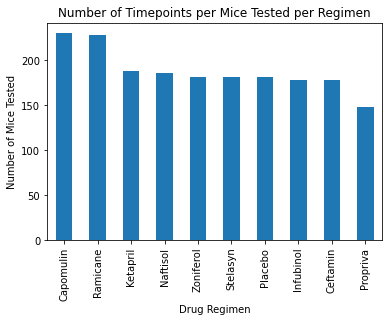

In [10]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using Pandas.
mouse_counter = group_mouse.count()["Timepoint"].sort_values(ascending=False)

mouse_bar = mouse_counter.plot.bar(x='Drug Regimen', y='Timepoint', rot=90, 
                                   title='Number of Timepoints per Mice Tested per Regimen', align="center")
mouse_bar.set_ylabel("Number of Mice Tested")

Text(0, 0.5, 'Number of Mice Tested')

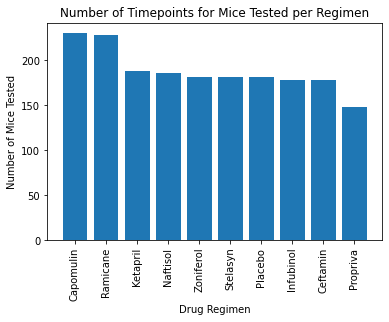

In [11]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using pyplot.
mouse_count = group_mouse.count()["Timepoint"].sort_values(ascending=False)
regimen = mouse_count.keys()

mouse_plot = plt.bar(mouse_count.keys(), mouse_count, align='center')

plt.title("Number of Timepoints for Mice Tested per Regimen")
plt.xticks(rotation='vertical')
plt.xlabel("Drug Regimen")
plt.ylabel("Number of Mice Tested")

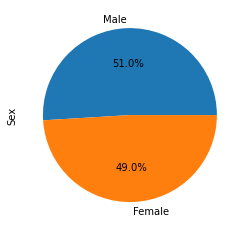

In [12]:
# Generate a pie plot showing the distribution of female versus male mice using Pandas
mouse_sex = clean_data["Sex"].value_counts()

mouse_sex_chart = mouse_sex.plot.pie(autopct="%1.1f%%")

Text(0.0, 1.0, 'Sex')

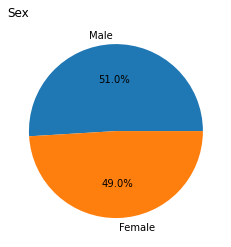

In [13]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
mouse_sex_chart2 = plt.pie(mouse_sex, labels=mouse_sex.keys(), autopct="%1.1f%%")

plt.title('Sex', loc='left')

## Quartiles, Outliers and Boxplots

In [14]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse
timepoint_data = clean_data.sort_values("Timepoint", ascending=True).groupby("Mouse ID").tail(1)["Timepoint"]


# Merge this group df with the original DataFrame to get the tumor volume at the last timepoint
time_merge = pd.merge(clean_data, timepoint_data, left_index=True, right_index=True)
time_merge = time_merge.reset_index().drop(columns=["index","Timepoint_y"]).rename(columns={"Timepoint_x": "Timepoint"})
time_merge

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,f932,0,45.000000,0,Ketapril,Male,15,29
1,x336,0,45.000000,0,Naftisol,Female,4,29
2,h428,0,45.000000,0,Ketapril,Female,1,27
3,v199,0,45.000000,0,Naftisol,Female,17,29
4,o848,0,45.000000,0,Stelasyn,Female,14,27
...,...,...,...,...,...,...,...,...
243,r944,45,41.581521,2,Capomulin,Male,12,25
244,u364,45,31.023923,3,Capomulin,Male,18,17
245,p438,45,61.433892,1,Ceftamin,Female,11,26
246,x773,45,58.634971,4,Placebo,Female,21,30


In [15]:
# Put treatments into a list for for loop (and later for plot labels)
treatments = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]

# Create empty list to fill with tumor vol data (for plotting)
tumor_vol = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 

    # Locate the rows which contain mice on each drug and get the tumor volumes
    
    
    # add subset 
    
    
    # Determine outliers using upper and lower bounds
    
for treats in treatments:
    quant = time_merge.loc[time_merge["Drug Regimen"] == treats]["Tumor Volume (mm3)"]
    if treats == "Capomulin":
        capo = quant
        quartiles = capo.quantile([.25,.50,.75]) 
        lowerq = quartiles[0.25]   
        upperq = quartiles[0.75]
        iqr = upperq-lowerq
        lower_bound = lowerq - (1.5*iqr)
        upper_bound = upperq + (1.5*iqr)
        tumor_size = capo
        outliers = tumor_size[(tumor_size < lower_bound) | (tumor_size > upper_bound)]
        print(f"Capomulin's potential outlier: {outliers}")
        
        
    elif treats == "Ramicane":
        rami = quant
        quartiles = rami.quantile([.25,.50,.75]) 
        lowerq = quartiles[0.25]   
        upperq = quartiles[0.75]
        iqr = upperq-lowerq
        lower_bound = lowerq - (1.5*iqr)
        upper_bound = upperq + (1.5*iqr)
        tumor_size = rami
        outliers = tumor_size[(tumor_size < lower_bound) | (tumor_size > upper_bound)] 
        print(f"Ramicane's potential outlier: {outliers}")
        
    elif treats == "Infubinol":
        infu = quant
        quartiles = infu.quantile([.25,.50,.75]) 
        lowerq = quartiles[0.25]   
        upperq = quartiles[0.75]
        iqr = upperq-lowerq
        lower_bound = lowerq - (1.5*iqr)
        upper_bound = upperq + (1.5*iqr)
        tumor_size = infu
        outliers = tumor_size[(tumor_size < lower_bound) | (tumor_size > upper_bound)] 
        print(f"Infubinol's potential outlier: {outliers}")
        
    elif treats == "Ceftamin":
        ceft = quant
        quartiles = ceft.quantile([.25,.50,.75]) 
        lowerq = quartiles[0.25]   
        upperq = quartiles[0.75]
        iqr = upperq-lowerq
        lower_bound = lowerq - (1.5*iqr)
        upper_bound = upperq + (1.5*iqr)
        tumor_size = ceft
        outliers = tumor_size[(tumor_size < lower_bound) | (tumor_size > upper_bound)] 
        print(f"Ceftamin's potential outlier: {outliers}")

tumor_vol = [capo, rami, infu, ceft]

Capomulin's potential outlier: Series([], Name: Tumor Volume (mm3), dtype: float64)
Ramicane's potential outlier: Series([], Name: Tumor Volume (mm3), dtype: float64)
Infubinol's potential outlier: 20    36.321346
Name: Tumor Volume (mm3), dtype: float64
Ceftamin's potential outlier: Series([], Name: Tumor Volume (mm3), dtype: float64)


Text(0, 0.5, 'Final Tumor Volume (mm3)')

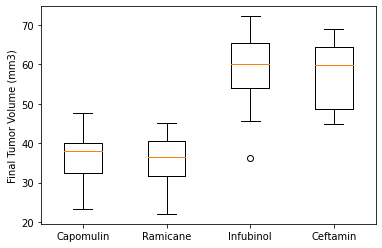

In [16]:
# Generate a box plot that shows the distrubution of the tumor volume for each treatment group.
boxplot = plt.boxplot(tumor_vol, labels=treatments)

plt.ylabel("Final Tumor Volume (mm3)")

## Line and Scatter Plots

Text(0, 0.5, 'Timepoint (days)')

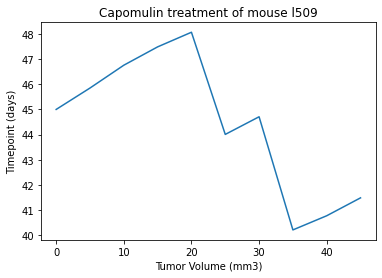

In [17]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin
l509 = clean_data.loc[clean_data["Mouse ID"] == "l509"]

mouse = plt.plot(l509["Timepoint"], l509["Tumor Volume (mm3)"])

plt.title("Capomulin treatment of mouse l509")
plt.xlabel("Tumor Volume (mm3)")
plt.ylabel("Timepoint (days)")

Text(0, 0.5, 'Average Tumor Volume (mm3)')

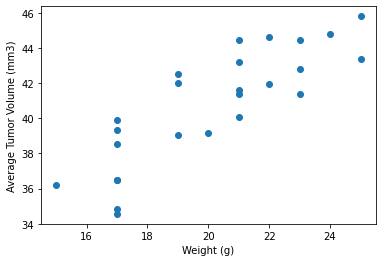

In [18]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen
capom = clean_data.loc[mouse_data["Drug Regimen"] == "Capomulin"]
capom_group = capom.groupby(["Mouse ID"]).mean()

avg_tum = capom_group["Weight (g)"]

mouse_tum = capom_group["Tumor Volume (mm3)"]

plt.scatter(avg_tum, mouse_tum, marker="o")

plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")

## Correlation and Regression

the correlation between mouse weight and the average tumor volume is 0.84


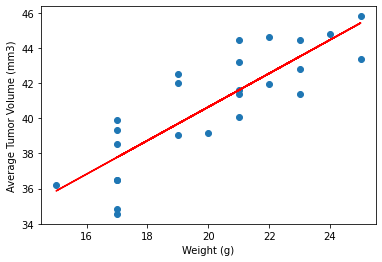

In [19]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen


capom = clean_data.loc[clean_data["Drug Regimen"] == "Capomulin"]
capom_group = capom.groupby(["Mouse ID"]).mean()

avg_tum = capom_group["Weight (g)"]
mouse_tum = capom_group["Tumor Volume (mm3)"]


x_values = avg_tum
y_values = mouse_tum
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

print(f"the correlation between mouse weight and the average tumor volume is {round(rvalue,2)}")

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r")
plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
plt.show()